# Mask R-CNN - Inspect WorkersDetection Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.workersDetection import workersDetection

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print(ROOT_DIR)

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
#BALLON_WEIGHTS_PATH = /home/sai/anaconda3/Mask_RCNN/logs/workersdetection20200806T0040/mask_rcnn_workersdetection_0030.h5  
# TODO: update this path

/home/sai/anaconda3/Mask_RCNN


## Configurations

In [2]:
config = workersDetection.WorkersDetectionConfig()
WORKERS_DIR = os.path.join(ROOT_DIR, "dataset")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
    

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = workersDetection.WorkersDetectionDataset()
dataset.load_workers(WORKERS_DIR, "val")

# Must call before using the dataset
dataset.prepare()

#print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
print("Classes: {}", dataset.class_names)

[{'name': 'polygon', 'all_points_x': [1188, 1177, 1203, 1234], 'all_points_y': [810, 877, 880, 793]}, {'name': 'polygon', 'all_points_x': [1173, 1159, 1114, 1120, 1189, 1197, 1260, 1267, 1331, 1332, 1303, 1292, 1281, 1295, 1275, 1247, 1265, 1229, 1212, 1166, 1194], 'all_points_y': [713, 830, 841, 867, 880, 797, 788, 865, 865, 836, 837, 749, 743, 647, 585, 590, 650, 669, 613, 632, 692]}, {'name': 'rect', 'x': 1092, 'y': 579, 'width': 261, 'height': 322}, {'name': 'rect', 'x': 1157, 'y': 614, 'width': 76, 'height': 49}]
Classes: {} ['BG', 'Safe', 'Unsafe', 'Worker', 'Safetybelt', 'Hardhat', 'Holder']





## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

ValueError: Tried to convert 'shape' to a tensor and failed. Error: None values not supported.

In [8]:

# Or, load the last model you trained
#weights_path = model.find_last()
#weights_path = os.path.join(MODEL_DIR, "workersdetection20200912T0051/mask_rcnn_workersdetection_0030.h5")#for 30 epochs only safe and unsafe
#weights_path = os.path.join(MODEL_DIR, "workersdetection20200828T1003/mask_rcnn_workersdetection_0060.h5") # for 60 epochs with safe and unsafe
#weights_path = os.path.join(MODEL_DIR, "workersdetection20200823T0233/mask_rcnn_workersdetection_0030.h5") # for 30 epoch
#weights_path = os.path.join(MODEL_DIR, "workersdetection20200824T0038/mask_rcnn_workersdetection_0060.h5") # for 60 epoch without rectangle boxes shapes
weights_path = os.path.join(MODEL_DIR, "workersdetection20200831T0142/mask_rcnn_workersdetection_0060.h5")# all classes except safe and unsafe

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/sai/anaconda3/Mask_RCNN/logs/workersdetection20200831T0142/mask_rcnn_workersdetection_0060.h5
Re-starting from epoch 60


## Run Detection

image ID: Workers.img3_0168.png (3) /home/sai/anaconda3/Mask_RCNN/dataset/val/img3_0168.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (14,)                 min:    1.00000  max:    6.00000  int32
gt_bbox                  shape: (14, 4)               min:  271.00000  max:  727.00000  int32
gt_mask                  shape: (1024, 1024, 14)      min:    0.00000  max:    1.00000  bool
num of classes in image: 12
GT_CLASSES
[5 6 4 5 3 3 1 2 5 5 3 3 1 1]
[3 4 5 5 3 5 5 3 3 6 6 5]


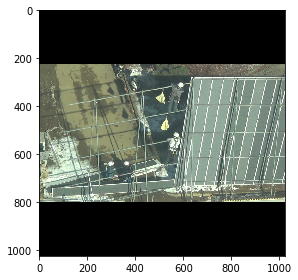

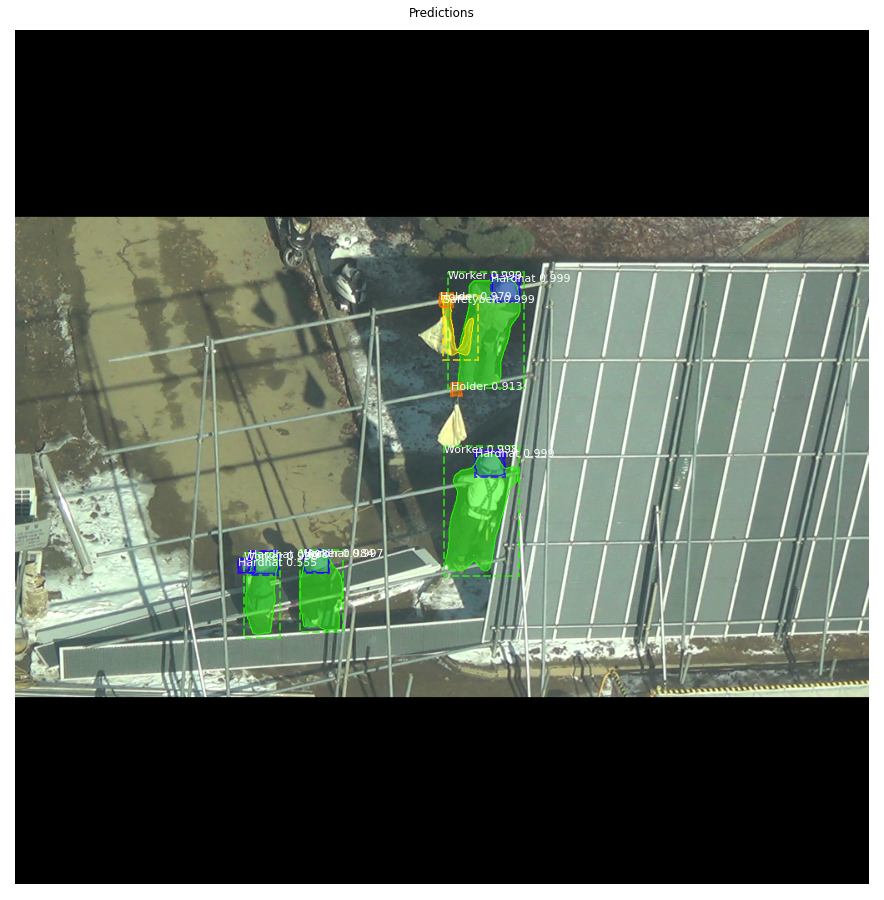

In [16]:
import skimage.io
image_id = random.choice(dataset.image_ids)
#image_id = 76
d=[35,26,70]
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
#image = skimage.io.imread("/home/sai/Desktop/test3.jpg")
skimage.io.imshow(image)
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
#print(r['masks'])
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print("num of classes in image: "+str(len(r['class_ids'])))
print("GT_CLASSES")
print(gt_class_id)
print(r['class_ids'])

In [10]:
n=list(r['class_ids']).count(3)  #number of classes
Ad_m=np.zeros((n,4,4),dtype=int) #create a matrix of m*m (m is number of classes)
#print(Ad_m)
m=0
for i,c in enumerate(r['class_ids']): 
    if c == 3: # Check for workers class
        bbw=r['rois'][i]
        # increase the bounding of the workers class
        bbw[0]*=0.9
        bbw[1]*=0.9
        bbw[2]*=1.1
        bbw[3]*=1.1
        f=0
        for j,bb in enumerate(r['rois']):
            #print(j)
            if i!=j:
                c1=r['class_ids'][j]
                if c1!=6: # check if the class is not hook
                    if bb[0]>=bbw[0] and bb[1]>=bbw[1] and bb[2]<=bbw[2] and bb[3]<=bbw[3]: #check whether there is any bb in workers bb
                        Ad_m[m][0][c1-3]=1 # set the worker row and c1 column to 1
                        Ad_m[m][c1-3][0]=1
                        if c1==4: # if the class is strap
                            f=1
                            bbs=bb
                            # decrease x1,y1 by 0.02% so that the hook can include in that
                            bbs[0]*=0.98
                            bbs[1]*=0.98
                elif f == 1: # check if the strap is detected and then check for hook
                    if bb[0]>=bbs[0] and bb[1]>=bbs[1] and bb[2]<=bbs[2] and bb[3] <= bbs[3]:
                        Ad_m[m][2][c1-3]=1
                        Ad_m[m][c1-3][2]=1
                        f=0
                else:
                    if bb[0]>=bbw[0] and bb[1]>=bbw[1] and bb[2]<=bbw[2] and bb[3]<=bbw[3] and bb[0]<=(bbw[2]+bbw[0])/2:
                        Ad_m[m][c1-3][2]=1
                        Ad_m[m][2][c1-3]=1
                        
        m+=1
        
print("Adjacent Matrix")
print(Ad_m)

for i,m in enumerate(Ad_m):
    if m[0][1] == 1 and m[0][2] == 1 and m[2][3] == 1:
        print("Worker:{} is safe".format(i+1))
    else:
        print("Worker:{} is unsafe".format(i+1))
                    
                    

Adjacent Matrix
[[[0 1 1 0]
  [1 0 0 0]
  [1 0 0 1]
  [0 0 1 0]]

 [[0 0 1 0]
  [0 0 0 0]
  [1 0 0 0]
  [0 0 0 0]]

 [[0 0 1 0]
  [0 0 0 0]
  [1 0 0 0]
  [0 0 0 0]]

 [[0 0 1 0]
  [0 0 0 0]
  [1 0 0 0]
  [0 0 0 0]]

 [[0 0 1 0]
  [0 0 0 0]
  [1 0 0 0]
  [0 0 0 0]]]
Worker:1 is safe
Worker:2 is unsafe
Worker:3 is unsafe
Worker:4 is unsafe
Worker:5 is unsafe


In [ ]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
print(precisions)
print(recalls)
visualize.plot_precision_recall(AP, precisions, recalls)

In [ ]:
"""def compute_ap_per_class(name_class, dataset, model, cfg):
    APs=[]
    #for image_id in dataset.image_ids:
    image_id = random.choice(dataset.image_ids)
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    scaled_image = mold_image(image, config)
    sample = expand_dims(scaled_image, 0)
    yhat = model.detect([image], verbose=0)
    r = yhat[0]
    AP, _, _, _ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'], name_class)
        #APs.append(AP)
    #mAP = mean(APs)
    return AP"""

In [ ]:
#def evaluate_model(dataset, model, cfg):
"""cn=['Safe','Unsafe','Worker','Safetybelt','Hardhat','Holder']
for c in cn:
    mAP = compute_ap_per_class(c, dataset, model, config)
    print('mAP: ', mAP)
"""

In [ ]:
import pandas as pd
gt_tot = np.array([])
pred_tot = np.array([])
mAP_ = []
d=[35,26,70,130]
for i,image_id in enumerate(dataset.image_ids):
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

    # Run object detection
    #skimage.io.imshow(image)
    #image = skimage.io.imread("/home/sai/Desktop/test.jpg")
    results = model.detect([image], verbose=1)

    # Display results
    #ax = get_ax(1)
    r = results[0]
    #print(r['masks'])
    #visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                #dataset.class_names, r['scores'], ax=ax,
                                #title="Predictions")
    #log("gt_class_id", gt_class_id)
    #log("gt_bbox", gt_bbox)
    #log("gt_mask", gt_mask)
    print(gt_class_id)
    print(r['class_ids'])
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'], iou_tresh = 0.5)
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    #precision_, recall_, AP_ = utils.compute_precision_recall_map(gt_tot, pred_tot)
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                      r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold = 0.5)
    """print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    print("the actual precision is : ", precision_)
    print("the actual recall is : ", recall_)
    #print("the actual overlaps is : ", overlap_)"""
    mAP_.append(AP_)
    #print("the actual average precision : ", AP_)
    #print("the actual mean average precision : ", sum(mAP_)/len(mAP_))

In [ ]:
#visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
#                        overlaps, dataset.class_names)

In [ ]:
import os
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "ourput"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))

#print the confusion matrix :

tp, fp, fn, df1 = utils._test_data_class(dataset.class_names, gt_tot, pred_tot)
print(df1)
ap,mrec,mprec=utils.voc_ap(tp, fp, fn)

print(ap)

#plot precision recall curve : 

utils.plot_precision_recall(ap, mprec, mrec)

In [ ]:
print(df1)
classes=['BG','Safe','Unsafe','Worker','Safetybelt','Hardhat','Holder']
atotal=[]
ptotal=[]
TP=[]
FN=[]
FP=[]
for i,c in enumerate(classes):
    atotal.append(sum(df1.loc[c]))
    ptotal.append(sum(df1[c]))
    TP.append(df1[c][c])
    FN.append(atotal[i]-TP[i])
    FP.append(ptotal[i]-df1[c][c])
for i in range(len(classes)):
    print("AP for class {:10}: {}".format(classes[i],float(TP[i]/(TP[i]+FP[i]))))
    print("RE for class {:10}: {}".format(classes[i],float(TP[i]/(tp[i]+FN[i]))))
    print()

In [ ]:
from sklearn.metrics import classification_report,precision_recall_curve
target_names = ['BG','Safe','Unsafe','Worker','Safetybelt','Hardhat','Holder']
print(classification_report(gt_tot, pred_tot, target_names=target_names))


In [ ]:
print("Mean AP: ",np.mean(mAP_))


In [ ]:
AP for class bg        : 0.0
RE for class bg        : 0.0

AP for class safe      : 0.3343717549325026
RE for class safe      : 0.49538461538461537

AP for class unsafe    : 0.488
RE for class unsafe    : 0.18100890207715134

AP for class worker    : 0.49946178686759957
RE for class worker    : 0.4663316582914573

AP for class safetybelt: 0.9891304347826086
RE for class safetybelt: 0.6546762589928058

AP for class hardhat   : 0.8927875243664717
RE for class hardhat   : 0.976545842217484

AP for class holder    : 0.8481012658227848
RE for class holder    : 0.6146788990825688


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /home/sai/anaconda3/Mask_RCNN/logs/workersdetection20200912T0051
#%tensorboard --logdir /home/sai/anaconda3/Mask_RCNN/logs/workersdetection20200831T0142

In [ ]:
precision, recall, thresholds = precision_recall_curve( gt_tot, pred_tot)

In [ ]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    Rs=[]
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        
        APs.append(AP)
        Rs.append(recalls)
    return APs,Rs

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 10)
APs,Rs = compute_batch_ap(dataset.image_ids)
print("mAP @ IoU=50: ", np.mean(APs))
print("recall: ",np.mean(Rs))

In [ ]:
mAP=np.mean(APs)
r=np.mean(Rs)
print("f score is: ",(2*mAP*r)/(mAP+r))

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Safe','Unsafe','Worker','Safetybelt','Hardhat','Holder']
print(classification_report(gt_, r['class_ids'], target_names=target_names))

In [ ]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          gt_bbox, gt_class_id, r['scores'], gt_mask)
visualize.plot_precision_recall(AP, precisions, recalls)

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

In [ ]:

import sys
import math
import numpy as np
import pandas as pd

data = pd.read_csv("/Users/sai/Downloads/data.csv")
f=data.groupby('location')

nc=[]
nd=[]
x_d=[]
correlation=[]
correlation_India=[]
countries=data['location'].unique()
diff=sys.float_info.max

j=-1
ind=f.get_group('India')
ind_mean=ind.mean(axis=0)
ind_a=((ind['new_cases'].subtract(ind_mean[0]))**2)
ind_b=((ind['new_deadths'].subtract(ind_mean[1]))**2)
sd_indnc=math.sqrt(ind_a.mean(axis=0))
sd_indnd=math.sqrt(ind_b.mean(axis=0))
su_indnc=(ind['new_cases'].subtract(ind_mean[0])/sd_indnc)
su_indnd=(ind['new_deaths'].subtract(ind_mean[1])/sd_indnd)
sp_ind=su_indnc*indnd
ind_corr=sp_ind.mean(axis=0)


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

for c in countries:
    if c == 'India':
        continue
    j+=1
    g=f.get_group(c)
    h=g.mean(axis=0)
    #g['new_cases'].sum()
    nc.append(h[0])
    nd.append(h[1])
    #print(g)
    n=g['new_cases']
    m=g['new_deaths']
    a=((n.subtract(nc[j]))**2)
    b=((m.subtract(nd[j]))**2)
    sd1=(math.sqrt(a.mean(axis=0)))
    sd2=(math.sqrt(b.mean(axis=0)))
    su1=((n.subtract(nc[j]))/sd1)
    su2=((m.subtract(nd[j]))/sd2)
    sp=su1*su2
    corr=sp.mean(axis=0)
    if diff>np.ads(corr-ind_corr):
        country_index=j
        nearest_corr=corr
    
print("Country with nearest India corrleated data is: ",countries[country_index])
print("India new_cases {:10} and new_deaths{:10}".format(ind['new_cases'],ind['new_deaths']))
print("India correlation value is: ",ind_corr)
print("{:10} new_cases {:10} and new_deaths{:10}".format(countries[country_index],f.get_group(countries[country_index])['new_cases'],f.get_group(countries[country_index])['new_deaths']))
print("{:10} correlation value is: ",nearest_corr)